### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 1st at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ same-colored burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

# <font color='green'>**PART ONE!**</font>

<font color='orange'>Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.</font>

Perfect! We start with some import statements and data organization below:

In [85]:
# Import statements
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats
import emcee

In [86]:
# Organizing the data
data = np.load("hw5_data_1.npy") # Loading the dataset
time_measurements = data[:, 0]  # First column is time measurements
flux_measurements = data[:, 1]  # Second column is flux measurements
flux_uncertainties = data[:, 2] # Third column is flux uncertainties

Now, we plot everything together:

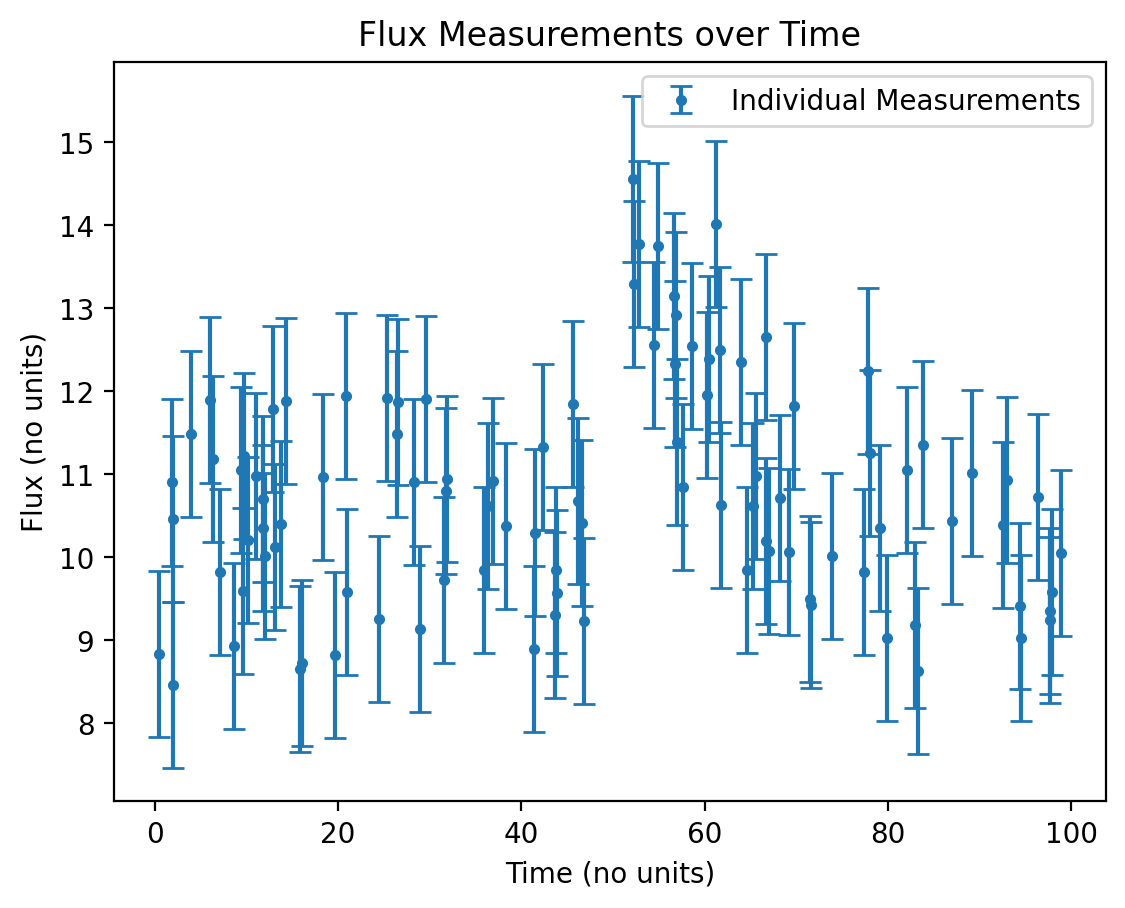

In [87]:
# Making the plot
#plt.plot(time_measurements, flux_measurements, label='A')
plt.errorbar(time_measurements, flux_measurements, yerr=flux_uncertainties, label='Individual Measurements', fmt='.', capsize=4)
plt.xlabel('Time (no units)')
plt.ylabel('Flux (no units)')
plt.title('Flux Measurements over Time')
plt.legend()
plt.show()

# <font color='green'>**PART TWO!**</font>

<font color='orange'> One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as: $y = b$, for $t<t_0$, and $y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$, where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off. Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* </font>

Below is the model as well as the likelihood functions. I hope you think it's cool :)

In [ ]:
# Defining the model function
def sharp_burst_exp_tail(theta, t):
    lnalpha, b, A, t_0 = theta
    alpha = np.exp(lnalpha)
    sharp_burst_exp_tail_result = np.zeros_like(t)
    for i in range(len(t)):
        if t[i] < t_0:
            sharp_burst_exp_tail_result[i] = b
        else:
            sharp_burst_exp_tail_result[i] = A * np.exp(-alpha * (t[i] - t_0))
    return sharp_burst_exp_tail_result

# Computing the data log-likelihood given a model
def log_likelihood_burst(theta, data, model=sharp_burst_exp_tail):
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return np.sum(stats.norm.logpdf(y, loc=y_fit, scale=sigma_y))

Doing a check to make sure our model works:

In [89]:
sharp_burst_exp_tail([1, 10, 5, 50], time_measurements)

array([1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
       1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
       1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
       1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
       1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
       1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
       1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
       1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
       1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
       1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
       1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
       1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
       1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.31734520e-02,
       9.00443346e-03, 1.94010028e-03, 2.51393512e-05, 8.63706132e-06,
      

Looks like a sharp burst to me! Let's carry on.

# <font color='green'>**PART THREE!**</font>

<font color='orange'> Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$. </font>

In order to start this off, we must first define functions for the log priors and posteriors:

In [90]:
def log_prior(x, loc, scale):
    return stats.uniform.logpdf(x, loc=loc, scale=scale)

def log_posterior(theta, data):
    lnalpha, b, A, t_0 = theta
    return log_likelihood_burst(theta, data) + log_prior(lnalpha, loc=-5, scale=10) + log_prior(b, loc=0, scale=50) + log_prior(A, loc=0, scale=50) + log_prior(t_0, loc=0, scale=100)

Once we have those in place, we can start the MCMC. I'm using emcee here, which requires us to define the number of dimensions (4 for each quantity in theta), the number of walkers searching through the data, and the total MCMC steps the sampler is taking (100000 in order to prevent issues of it being too small). Note that data burning will come later.

We initialize the first set of parameters in theta to start the chain off, and then use emcee.EmsembleSampler (MCMC with multiple walkers) to run this thing. Let's do it!!!

In [91]:
# Creating the MCMC sampler using emcee
ndim = 4
nwalkers = 64
nsteps = 200000

# Initializing theta (ndim=4)
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# Calling the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[[time_measurements, flux_measurements, flux_uncertainties]])
sampler.run_mcmc(starting_guesses, nsteps)

State([[-3.90087614 10.68039231 26.86065861 98.99762065]
 [-4.91150063 10.2483883  13.45266074 47.96452946]
 [-4.84721664 10.30692772 13.46543155 48.49928013]
 [ 1.31140682 10.48060648 28.70660417 99.09926615]
 [-4.88364587 10.38045661 13.17873876 47.70607995]
 [-4.91672074 10.49964707 12.86211533 50.06782228]
 [-4.78851086 10.42139967 13.12572007 49.99716754]
 [-4.88239259 10.5086527  13.53121142 47.83773099]
 [-4.88847693 10.66682377 13.35471693 48.91498028]
 [-4.93744187 10.31389927 12.44952842 50.33179785]
 [-4.89027575 10.4599749  12.82116165 49.6456992 ]
 [-4.80166291 10.43841502 13.17717531 51.14285326]
 [-4.76895356 10.26755817 13.52613553 46.9434655 ]
 [-4.87484037 10.52791141 12.9603363  50.58463575]
 [-4.85417977 10.22792581 12.88449839 51.49471506]
 [-4.90074883 10.35887925 12.98701624 49.36256961]
 [-4.93331414 10.52283725 13.15472578 48.85437179]
 [-4.83250334 10.32675756 13.51891965 47.64562962]
 [-4.74741719 10.59274423 12.99788128 51.91227301]
 [-4.80335186 10.28234168

# <font color='green'>**PART FOUR!**</font>

<font color='orange'>Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).</font>

DAMN that took forever! Now that the MCMC is behind us, let's focus on burning and thinning the data. We first extract the chains from the sampler for each of the dimensions (note the data organization here), and then extract the autocorrelation time/burn-in value through other various methods.

In [209]:
emcee_trace  = sampler.chain[:, 0:, :].reshape(-1, ndim)

Now, I am going to check the chains for bad walkers!

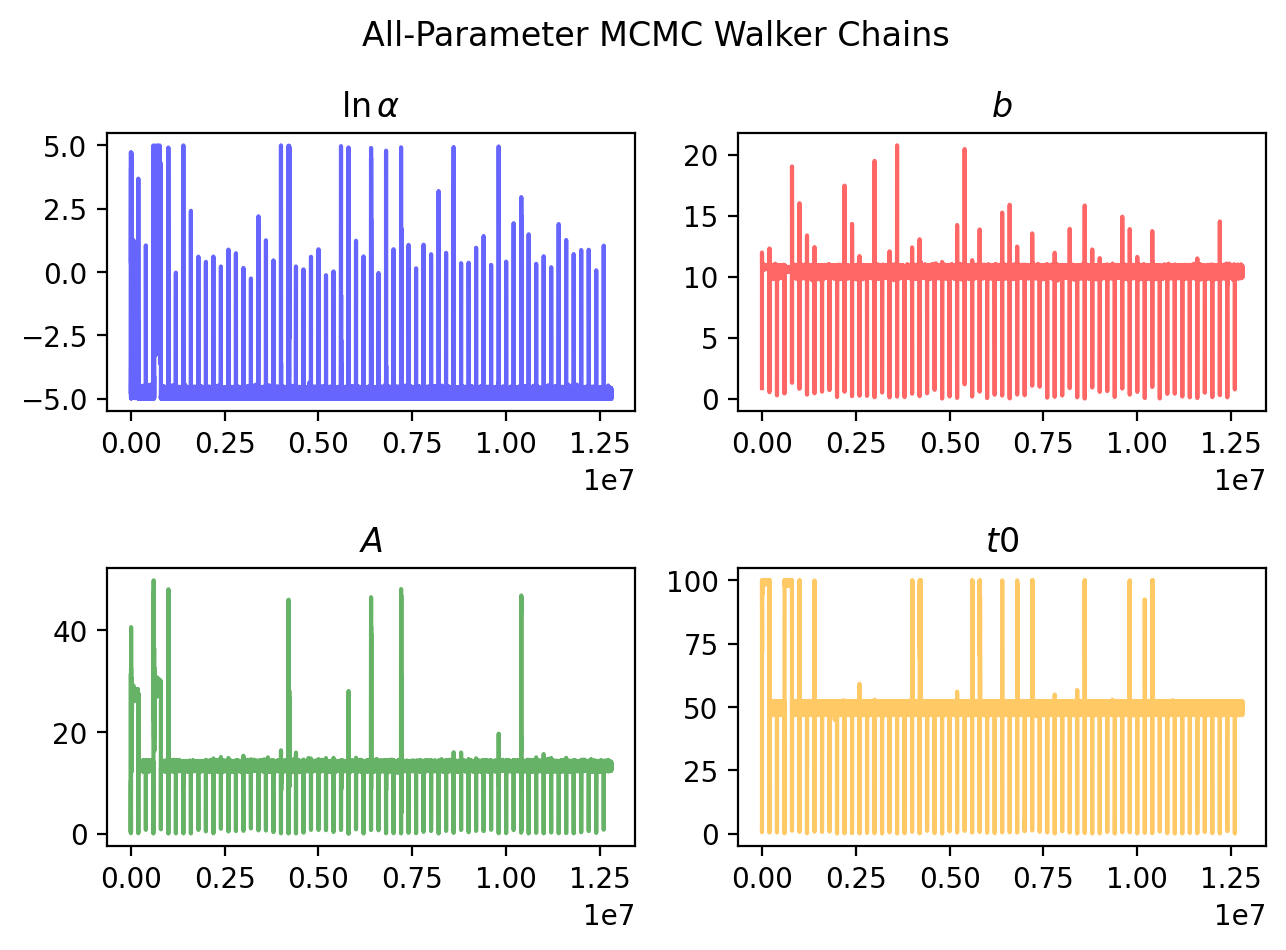

In [192]:
# Graphing the initial walker spread!
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.plot(emcee_trace[:, 0], color='blue', alpha=0.6)
ax1.set_title(r"$\ln\alpha$")
ax2.plot(emcee_trace[:, 1], color='red', alpha=0.6)
ax2.set_title(r"$b$")
ax3.plot(emcee_trace[:, 2], color='green', alpha=0.6)
ax3.set_title(r"$A$")
ax4.plot(emcee_trace[:, 3], color='orange', alpha=0.6)
ax4.set_title(r"$t0$")
plt.suptitle("All-Parameter MCMC Walker Chains")
plt.tight_layout()
plt.show()

We have a few bad walkers!! You can see them visually clustered at the beginning. Here's a view of one that sucks (the first one in the lnalpha parameter, actually!)

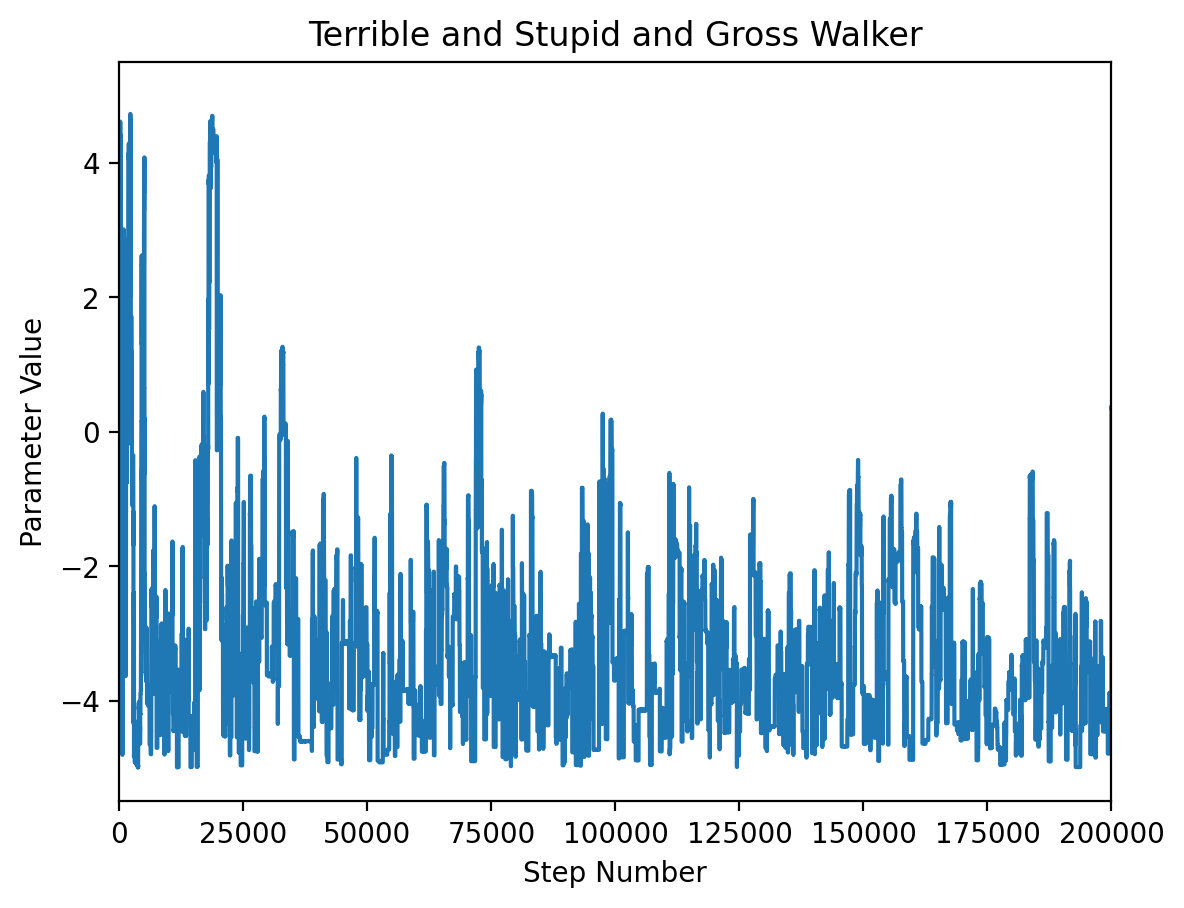

In [ ]:
# Plotting bad walker (lnalpha, walker 1)
plt.plot(emcee_trace[:, 0])
plt.xlim(0, 200000)
plt.title('Terrible and Stupid and Gross Walker')
plt.xlabel('Step Number')
plt.ylabel('Parameter Value')
plt.show()

Look at that! Gross!!! Here's a good one for reference:

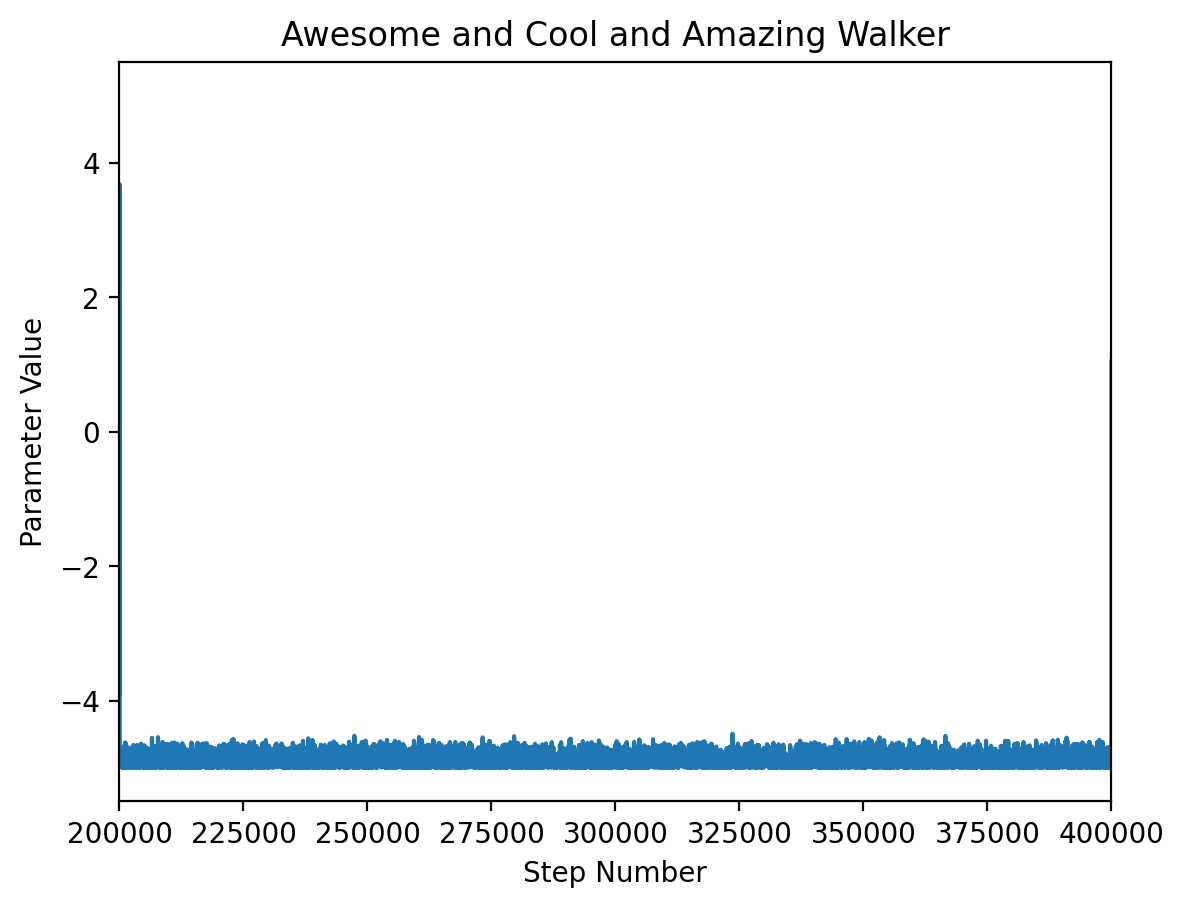

In [ ]:
# Plotting good walker (lnalpha, walker 2)
plt.plot(emcee_trace[:, 0])
plt.xlim(200000, 400000)
plt.title('Awesome and Cool and Amazing Walker')
plt.xlabel('Step Number')
plt.ylabel('Parameter Value')
plt.show()

Look at that! Very well behaved!

In order for a wlaker to be declared good, I am going to check if, by about 25,000 steps (what I plan to burn in, for safety reasons), the walker converges around a point (the max/min parameter values aren't more than 1 apart). If the variance is too big and a walker doesn't converge, I remove it!!!!

In [ ]:
# Defining burn-in value
burnin = 25000

# Reshaping emcee_trace back to (nwalkers, nsteps, ndim)
trace_reshaped = emcee_trace.reshape(nwalkers, nsteps, ndim)

# Identifying bad walkers
# NOTE THIS!! I chose 1.55 since it removed the bad walkers 
# without removing ALL of them. I hope that works for you too!
bad_walker_indices = []
for j in range(nwalkers):
    walker_std_devs = [np.std(trace_reshaped[j, burnin:, i]) for i in range(ndim)] # Retrieving the std devs
    if any(std > 1.55 for std in walker_std_devs):  # Seeing if any are larger, and then flagging them if they are
        bad_walker_indices.append(j)

# Ensuring unique & sorted indices (important for np.delete!!!!)
bad_walker_indices = sorted(set(bad_walker_indices))

# Debugging info (for my sanity)
print("Total walkers:", nwalkers)
print("Bad walkers removed:", len(bad_walker_indices))
print("Remaining walkers:", (nwalkers - len(bad_walker_indices)))

# Removing bad walkers
if len(bad_walker_indices) > 0:
    emcee_trace_cleaned = np.delete(trace_reshaped, bad_walker_indices, axis=0).reshape(-1, ndim)
else:
    print("Warning: No walkers were removed!")
    emcee_trace_cleaned = emcee_trace  # Here, keep original trace if nothing was removed.

# Double-check the new trace shape
print(f"New trace shape: {emcee_trace_cleaned.shape}")

Total walkers: 64
Bad walkers removed: 4
Remaining walkers: 60
New trace shape: (12000000, 4)


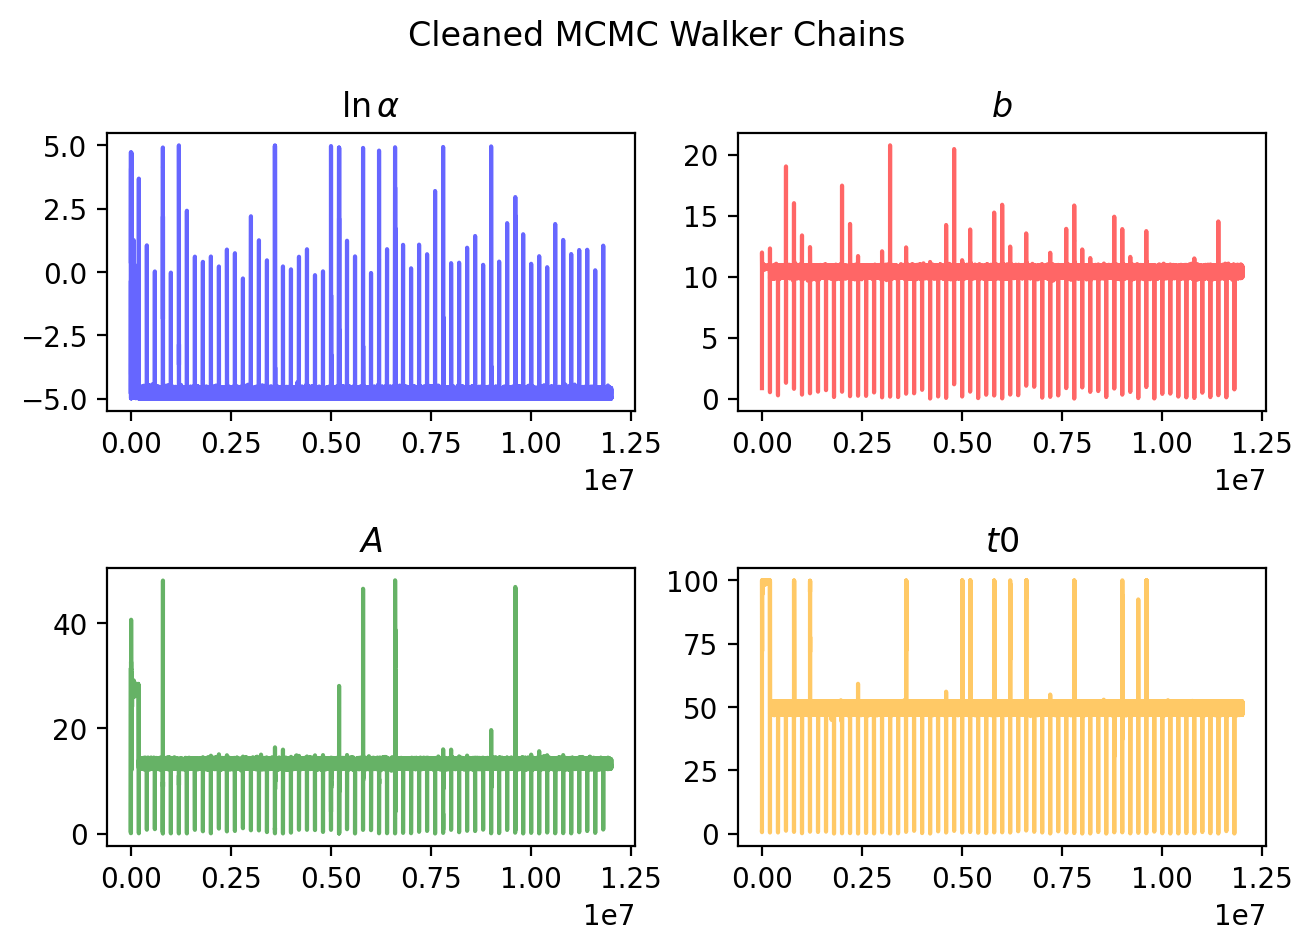

In [195]:
# Redoing the graphs to see them cleaned!
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.plot(emcee_trace_cleaned[:, 0], color='blue', alpha=0.6)
ax1.set_title(r"$\ln\alpha$")
ax2.plot(emcee_trace_cleaned[:, 1], color='red', alpha=0.6)
ax2.set_title(r"$b$")
ax3.plot(emcee_trace_cleaned[:, 2], color='green', alpha=0.6)
ax3.set_title(r"$A$")
ax4.plot(emcee_trace_cleaned[:, 3], color='orange', alpha=0.6)
ax4.set_title(r"$t0$")
plt.suptitle("Cleaned MCMC Walker Chains")
plt.tight_layout()
plt.show()

Oh no!!! The first gross walker survived the onslaught!! I am going to remove it manually (systematizing can only get you so far). That should do it!

In [ ]:
emcee_trace_cleaned = np.delete(emcee_trace_cleaned, np.s_[:200000], axis=0)

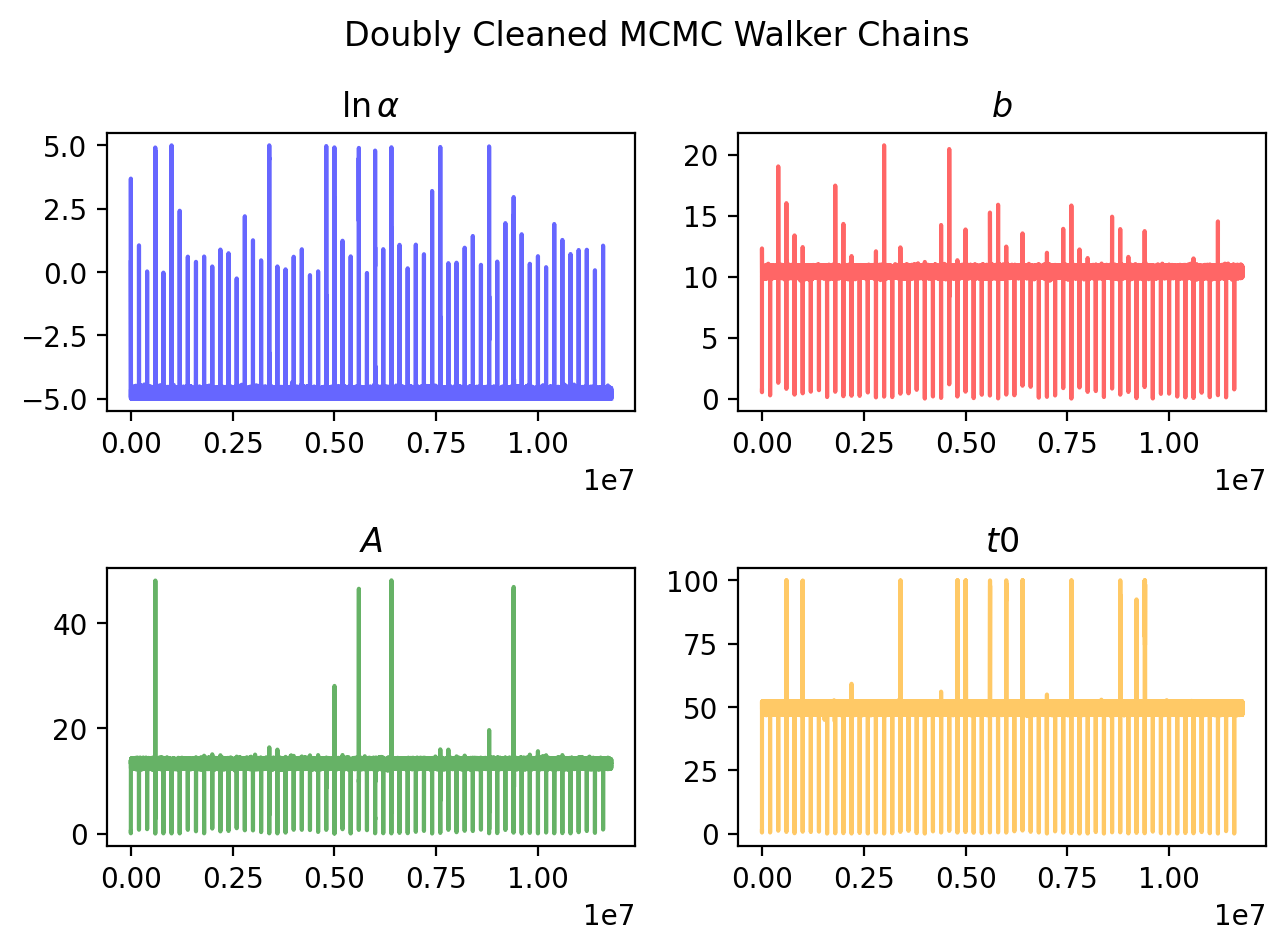

In [197]:
# Reredoing the graphs to see them cleaned!
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.plot(emcee_trace_cleaned[:, 0], color='blue', alpha=0.6)
ax1.set_title(r"$\ln\alpha$")
ax2.plot(emcee_trace_cleaned[:, 1], color='red', alpha=0.6)
ax2.set_title(r"$b$")
ax3.plot(emcee_trace_cleaned[:, 2], color='green', alpha=0.6)
ax3.set_title(r"$A$")
ax4.plot(emcee_trace_cleaned[:, 3], color='orange', alpha=0.6)
ax4.set_title(r"$t0$")
plt.suptitle("Doubly Cleaned MCMC Walker Chains")
plt.tight_layout()
plt.show()

Beautiful job! Cleaned and ready to go!

Now, in order to get autocorrelation time, we can use the emcee backend "get_autocorr_time", discarding the burn in to get the best set of values possible. We find the autocorrelation length and 'thin' the chain by selecting values every autocorrelation length (basically trying to avoid the effects of when the signal overlaps with a delayed copy of itself. Not good for avoiding biased results!).

In [ ]:
# Reshaping the array
nwalkers_new = emcee_trace_cleaned.shape[0] // nsteps 
trace_reshaped_cleaned = emcee_trace_cleaned.reshape(nwalkers_new, nsteps, ndim)

# Removing burn-in
post_burnin_trace = trace_reshaped_cleaned[:, burnin:, :]  # Shape is now (nwalkers_new, nsteps - burnin, ndim)

# Computing autocorrelation manually for each parameter (compute ACF for each 
# walker, find when it drops below 1/e, and then take the biggest ones)
# https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#autocorr
autocorr_times = []
for i in range(ndim):
    tau_list = []
    for j in range(nwalkers_new):
        acf = emcee.autocorr.function_1d(post_burnin_trace[j, :, i])  # Finding acfs
        tau = np.argmax(acf < np.exp(-1))  # Finding when the tau drop is
        tau_list.append(tau)
    autocorr_times.append(np.max(tau_list)) # Appending the worst case to the main list

# Get final autocorrelation time (finding the max autocorrelaiton time, and rounding up to an int)
autocorr_time = int(np.ceil(np.max(autocorr_times)))
print("Autocorrelation time (using function_1d):", autocorr_time)


Autocorrelation time (using function_1d): 40


Beautiful!! Now, le'ts burn-in and thin this guy for the final chain!!

In [ ]:
# Reshaping the cleaned trace
trace_final_cleaned = post_burnin_trace.reshape(nwalkers_new, nsteps - burnin, ndim)

# The final, thinned, burned-in trace!
trace_final = trace_final_cleaned[:, ::autocorr_time, :].reshape(-1, ndim)

# Debugging: Checking the shape
print(f"Thinned chain shape: {trace_final.shape}")


Thinned chain shape: (258125, 4)


# <font color='green'>**PART FIVE!**</font>

<font color='orange'> Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles. </font>

Here, I make the corner plot. I checked the shape of the thinned_chains_flat object to make sure it would be good here. Behold!!!

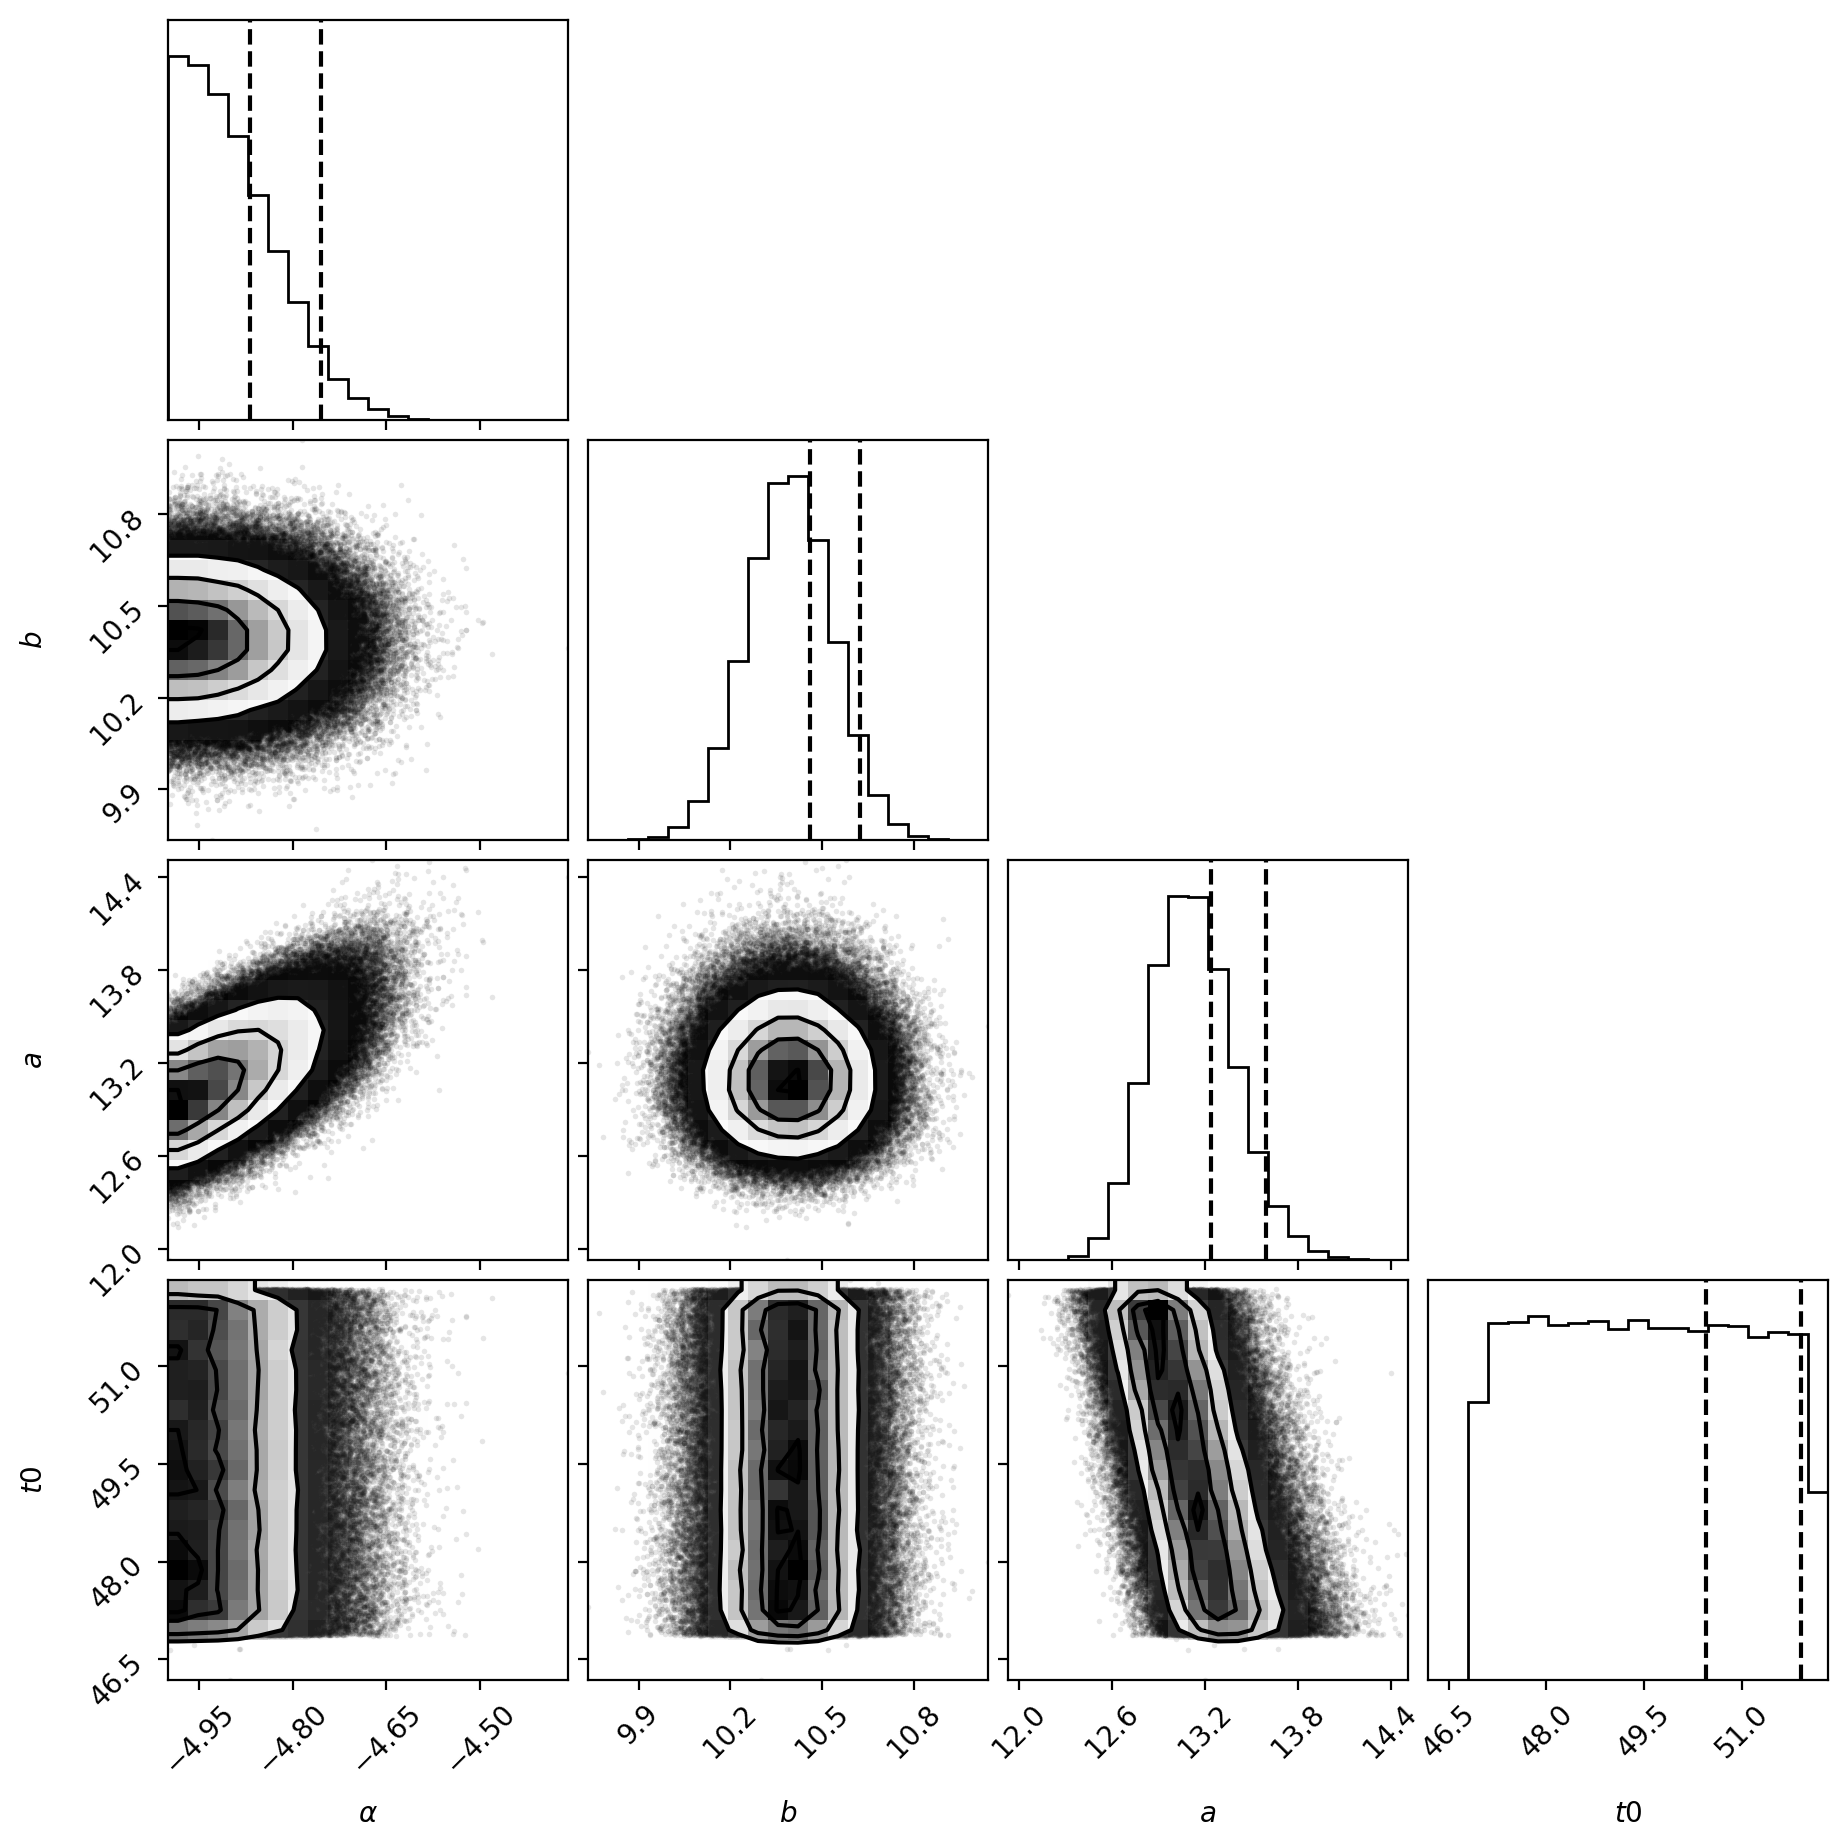

In [245]:
import corner # Useful import lol

# Making the corner plot
figure = corner.corner(trace_final, labels=[r'$\alpha$', r'$b$', r'$a$', r'$t0$'], quantiles = [0.68, 0.95]) # The actual corner plot

# <font color='green'>**PART SIX!**</font>

<font color='orange'> Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ same-colored burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data. </font>

Okay! For this step, we first select 100 random values from the flat, thinned chains (used np.random.choice). For plotting purposes, I made an x-range (the linspace of all t-values between the biggest and the smallest), generated 100 model curves, and then made a little for-loop to plot them all, plotting the original data on top.

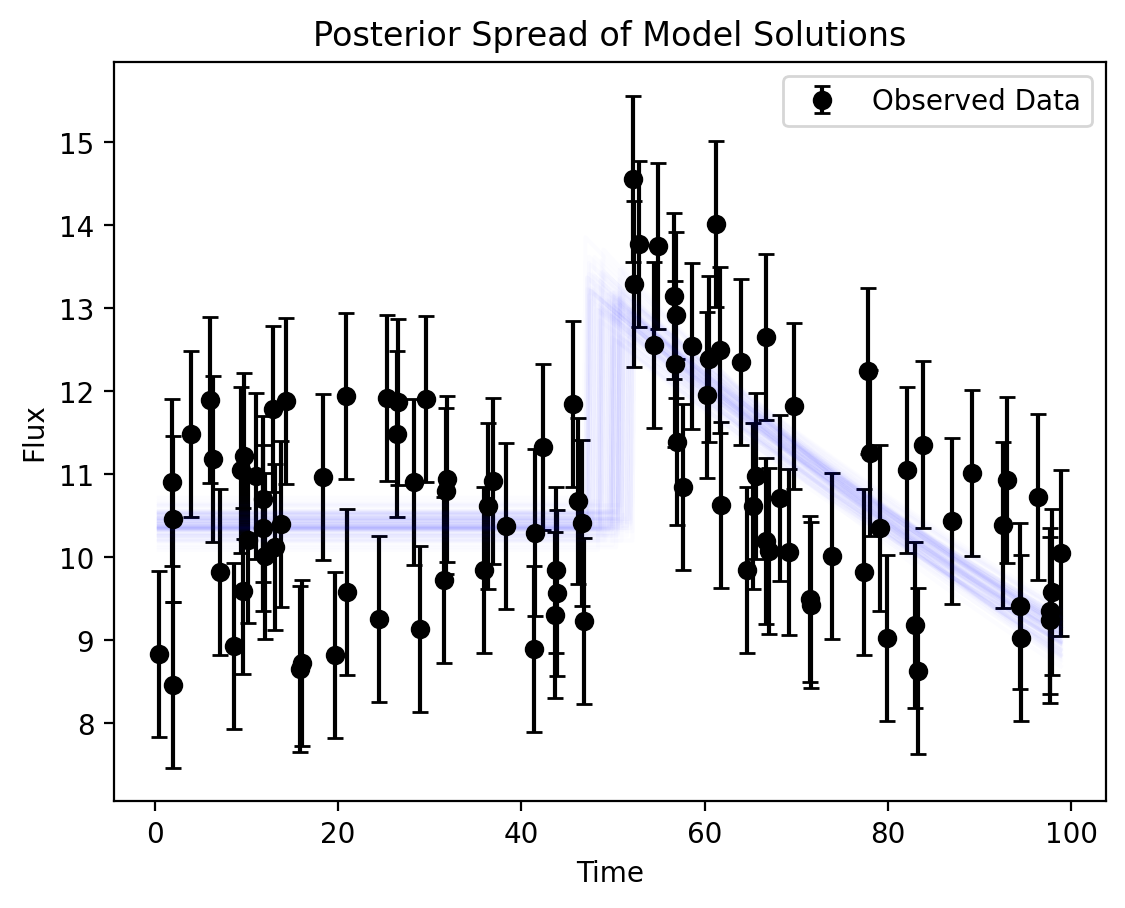

In [238]:
# Selecting 100 random valuess from the thinned chain
random_indices = np.random.choice(trace_final.shape[0], 100, replace=False)
random_samples = trace_final[random_indices]

# Time range for plotting our model curves
t_plot = np.linspace(min(time_measurements), max(time_measurements), 500) 

# Generating 100 burst time-series using the randomly selected parameters
model_curves = np.array([sharp_burst_exp_tail((lnalpha, b, A, t_0), t_plot) for (lnalpha, b, A, t_0) in random_samples])

# Plotting the original data points
plt.errorbar(time_measurements, flux_measurements, yerr=flux_uncertainties, fmt='o', color='black', label="Observed Data", capsize=3)

# Plotting the 100 model curves with transparency
for curve in model_curves:
    plt.plot(t_plot, curve, color='blue', alpha=0.01)  # Adjust alpha for visibility

# Formatting
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Posterior Spread of Model Solutions")
plt.legend()
plt.show()


# <font color='green'>**PART SEVEN!**</font>

<font color='orange'> Another possible model that may explain the data is a Gaussian profile described by: 
$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$. The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.* </font>

For the final part, we define the gaussian burst model as indicated in the question statement. Also, I am redefining the log likelihood functions to only contain theta, as I found out the hard way, dynesty does not like when it is given inputs of data, even if I creat the tuple for it and stick it in as logL_args. Oh well. Worth a shot!

The use of the hypercube to transform the priors is a little trickier. The unit cube sampling for Lecture 12 (10 * (2 * u - 1)), ranging from -10 to 10, works because it spans the space from 0 to 1, meaning the values have the appropriate range. Now, we have a hypercube that ranges from 0 to 1 in four dimensions representing each of our parameters. I have set up each parameter so that it spans between the appropriate values (0 to 50, 0 to 100, and logarithmic -2 to 2). That way, we are good for dynesty!

In [239]:
# The definition of the gaussian burst model
def gaussian_burst_model(b, A, sigma_W, t_0, t):
    return b + A * np.exp(-((t - t_0) ** 2) / (2 * sigma_W ** 2))

# Transforming the unit hypercube into the prior space
def prior_transform(u):
    b = 0 + 50 * u[0]  # Uniform(0, 50) distribution
    A = 0 + 50 * u[1]  # Uniform(0, 50) distribution too
    t_0 = 0 + 100 * u[2]  # Uniform(0, 100) distribution three :)
    ln_sigma_W = -2 + 4 * u[3]  # Uniform(-2, 2) distribution four!
    sigma_W = np.exp(ln_sigma_W)  # Transform OVER to sigma_W. You have to do this!!!
    return b, A, sigma_W, t_0

# Rewriting the log-likelihood functions to NOT take data as an argument for later
def log_likelihood_burst_no_data(theta):
    y_fit = sharp_burst_exp_tail(theta, time_measurements)
    return np.sum(stats.norm.logpdf(flux_measurements, loc=y_fit, scale=flux_uncertainties))

# And again!
def log_likelihood_gaussian_no_data(theta):
    b, A, sigma_W, t_0 = theta 
    y_fit = gaussian_burst_model(b, A, sigma_W, t_0, time_measurements)
    return np.sum(stats.norm.logpdf(flux_measurements, loc=y_fit, scale=flux_uncertainties))


Here, we use dynesty to get the Bayes factor for the gaussian burst model.

In [240]:
import dynesty

# Initializing the nested sampler
ndim = 4
sampler = dynesty.NestedSampler(log_likelihood_gaussian_no_data, prior_transform, ndim, nlive=500)

# Running the nested sampling
sampler.run_nested(dlogz=0.01, print_progress=True)

# Getting the Bayesian evidence (logZ)
results = sampler.results
logZ_gaussian = results.logz[-1]

print(f"Bayesian Evidence (logZ) for Gaussian Model: {logZ_gaussian:.3f}")


iter: 4144 | bound: 53 | nc: 88 | ncall: 58065 | eff(%):  7.137 | loglstar:   -inf < -178.274 <    inf | logz: -186.482 +/-  0.118 | dlogz: 33.170 >  0.010                                           /Users/blakeghg/miniconda3/envs/astr8070/lib/python3.10/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/Users/blakeghg/miniconda3/envs/astr8070/lib/python3.10/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused 

Bayesian Evidence (logZ) for Gaussian Model: -159.914


Now, we do the same for the sharp burst model.

In [ ]:
# Run dynesty for the burst model
sampler_burst = dynesty.NestedSampler(log_likelihood_burst_no_data, prior_transform, ndim=4, nlive=500)
sampler_burst.run_nested(dlogz=0.01, print_progress=True)
results_burst = sampler_burst.results
logZ_burst = results_burst.logz[-1]

print(f"Bayesian Evidence (logZ) for Burst Model: {logZ_burst:.3f}")

iter: 7220 | +500 | bound: 21 | nc: 1 | ncall: 33689 | eff(%): 23.261 | loglstar:   -inf < -178.984 <    inf | logz: -188.799 +/-  0.136 | dlogz:  0.000 >  0.010                                     

Bayesian Evidence (logZ) for Burst Model: -188.799


And the winner is...

In [242]:
bayes_factor = np.exp(logZ_gaussian - logZ_burst)
print(f"Bayes Factor (Gaussian vs. Burst): {bayes_factor:.3f}")

Bayes Factor (Gaussian vs. Burst): 3504819939378.142


WOW!!!!! The gaussian burst model is SHOCKINGLY better! Thus, we will stick to it in the future and finish out here!